In [418]:
from music21 import *
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

In [419]:
%matplotlib inline

In [420]:
path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven'

In [421]:
files = glob.glob('{}/*.mid*'.format(path))

In [422]:
files

['/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/212BeSon.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/beets3m3.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/1742bps26no23.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/pathet1.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/rondo.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/beeth9-3.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/1469no32variations.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/beeth9-2.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/2323andanteSteven.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/beet27m3.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/2264sechsSteven.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/beethoven/frhlingssonataop24.mid',
 '/

In [423]:
coluna1 = []
coluna2 = []
for file in files:
    midi = converter.parse(data_fn)
    part0 = midi[0]
    melodia = part0.getElementsByClass(note.Note)
    notas = melodia.getElementsByClass(note.Note)
    for nota in notas:
        coluna1.append(nota.midi)
        coluna2.append(nota.duration.quarterLength)

In [424]:
df = pd.DataFrame({"nota":coluna1,
                   "duracao":coluna2})

In [425]:
df.head()

,duracao,nota
0,0.25,50
1,4/3,50
2,0.25,50
3,4/3,53
4,0.25,53


In [426]:
df.tail()

,duracao,nota
7067,0,55
7068,0,57
7069,2/3,58
7070,0.25,60
7071,5/3,58


In [427]:
df.describe()

,nota
count,7072.000000
mean,54.413462
std,3.452140
min,46.000000
25%,53.000000
50%,55.000000
75%,57.000000
max,62.000000


In [428]:
df['nota'].unique()

array([50, 53, 55, 51, 58, 48, 46, 52, 57, 60, 62])

In [429]:
df['duracao'].unique()

array([0.25, Fraction(4, 3), Fraction(2, 3), 2.0, Fraction(1, 3), 1.0,
       Fraction(7, 3), 0.0, 1.25, Fraction(8, 3), 2.75, 0.75,
       Fraction(5, 3)], dtype=object)

In [430]:
mlb = MultiLabelBinarizer()

In [431]:
mlb.fit(df.values)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [432]:
classes = mlb.classes_

In [433]:
classes

array([0.0, 0.25, Fraction(1, 3), Fraction(2, 3), 0.75, 1.0, 1.25,
       Fraction(4, 3), Fraction(5, 3), 2.0, Fraction(7, 3),
       Fraction(8, 3), 2.75, 46, 48, 50, 51, 52, 53, 55, 57, 58, 60, 62],
      dtype=object)

In [434]:
classes.shape

(24,)

In [435]:
labels = mlb.transform(df.values)

In [436]:
labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [437]:
labels.shape

(7072, 24)

In [438]:
array_notas = df['nota'].values.astype(int)

In [439]:
array_notas.shape

(7072,)

In [440]:
array_duracao = df['duracao'].values.astype(float)

In [441]:
scaler = StandardScaler()
rawX = scaler.fit_transform(df.values)

/home/eurismar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [442]:
rawX

array([[-0.76703884, -1.27856145],
       [ 0.79007304, -1.27856145],
       [-0.76703884, -1.27856145],
       ...,
       [-0.16814966,  1.03900528],
       [-0.76703884,  1.61839696],
       [ 1.26918439,  1.03900528]])

In [443]:
scaler.inverse_transform(rawX[0])

array([ 0.25, 50.  ])

In [444]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, rawX.shape[0] - seq_length, 1):
	seq_in = rawX[i:i + seq_length]
	seq_out = labels[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  6972


In [445]:
X = np.reshape(dataX, (len(dataX), seq_length, 2))
y = np.asarray(dataY)

In [446]:
X.shape

(6972, 100, 2)

In [447]:
y.shape

(6972, 24)

In [448]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 2),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='sigmoid'))
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam,metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 256)          265216    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                6168      
Total params: 796,696
Trainable params: 796,696
Non-trainable params: 0
_________________________________________________________________
None


In [449]:
history = model.fit(X, y, epochs=10,batch_size=32, verbose=1, shuffle=False)

Epoch 1/10
6972/6972 [==============================] - 74s - loss: 0.2665 - acc: 0.9050    
Epoch 2/10
6972/6972 [==============================] - 65s - loss: 0.2067 - acc: 0.9180    
Epoch 3/10
6972/6972 [==============================] - 66s - loss: 0.1484 - acc: 0.9326    
Epoch 4/10
6972/6972 [==============================] - 70s - loss: 0.0834 - acc: 0.9678    
Epoch 5/10
6972/6972 [==============================] - 70s - loss: 0.0285 - acc: 0.9956    
Epoch 6/10
6972/6972 [==============================] - 64s - loss: 0.0506 - acc: 0.9865    
Epoch 7/10
6972/6972 [==============================] - 62s - loss: 0.0861 - acc: 0.9698    
Epoch 8/10
6972/6972 [==============================] - 63s - loss: 0.0150 - acc: 0.9991    
Epoch 9/10
6972/6972 [==============================] - 62s - loss: 0.0068 - acc: 0.9999    
Epoch 10/10
6972/6972 [==============================] - 62s - loss: 0.0043 - acc: 1.0000    


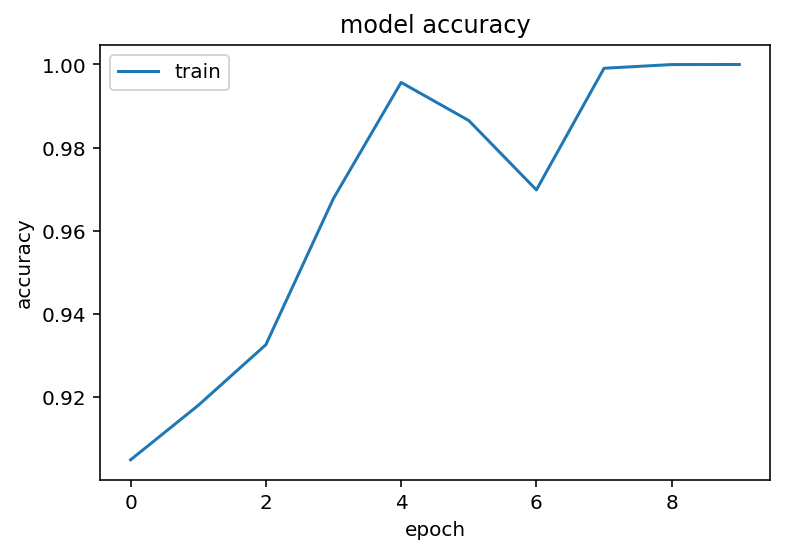

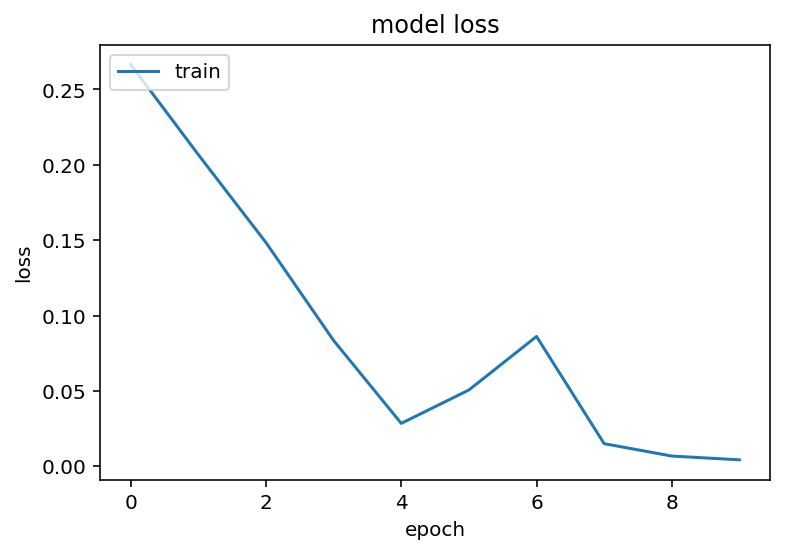

In [450]:

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Prevendo somente uma label**

In [460]:
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
p = np.reshape(pattern, (1, len(pattern), 2))
prediction = model.predict(p, verbose=0)
idxs = np.argsort(prediction[0])[::-1][:2]
print('idxs:',idxs)
new_pattern = [mlb.classes_[idxs[0]],mlb.classes_[idxs[1]]]
print('antes sort:',new_pattern)
new_pattern.sort()
print('depois sort:',new_pattern)
t = np.asarray(new_pattern)
t1 = t.reshape(1,2)
print(t1)
pt = scaler.transform(t1)
print(pt)

idxs: [20  2]
antes sort: [57, Fraction(1, 3)]
depois sort: [Fraction(1, 3), 57]
[[Fraction(1, 3) 57]]
[[-0.64726101  0.74930944]]


/home/eurismar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## **Prevendo uma sequencia**

In [452]:
len(dataX)

6972

In [511]:
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
for i in range(200):
    p = np.reshape(pattern, (1, len(pattern), 2))
    prediction = model.predict(p, verbose=0)
    idxs = np.argsort(prediction[0])[::-1][:2]
    new_pattern = [mlb.classes_[idxs[0]],mlb.classes_[idxs[1]]]
    new_pattern.sort()
    t = np.asarray(new_pattern).reshape(1,2)
    pt = scaler.transform(t)
    a = np.concatenate((pattern,pt))
    b = a[1:len(a)]
    pattern = b

/home/eurismar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [512]:
pattern

array([[-0.76703884,  0.16991775],
       [ 1.74829574,  1.03900528],
       [ 0.31096169,  1.03900528],
       [-0.76703884,  1.03900528],
       [ 1.74829574,  2.19778864],
       [ 0.79007304,  1.61839696],
       [-0.76703884, -0.40947393],
       [ 2.22740709,  1.03900528],
       [-0.16814966,  0.74930944],
       [-0.76703884,  0.16991775],
       [ 2.70651844, -0.40947393],
       [-1.12637236, -0.40947393],
       [-1.12637236,  0.74930944],
       [-0.16814966,  0.16991775],
       [-0.76703884, -0.40947393],
       [ 2.22740709, -0.40947393],
       [-0.76703884,  1.03900528],
       [ 2.82629628,  1.61839696],
       [-0.64726101, -0.40947393],
       [ 2.22740709,  2.19778864],
       [-0.04837182,  1.61839696],
       [ 0.67029521,  1.03900528],
       [-0.64726101,  1.03900528],
       [-0.64726101,  0.74930944],
       [-1.12637236,  1.03900528],
       [-1.12637236,  0.74930944],
       [-1.12637236,  0.16991775],
       [-1.12637236,  0.74930944],
       [-0.16814966,

In [513]:
pattern.shape

(100, 2)

In [514]:
inverso = scaler.inverse_transform(pattern)

In [515]:
inverso

array([[ 0.25      , 55.        ],
       [ 2.        , 58.        ],
       [ 1.        , 58.        ],
       [ 0.25      , 58.        ],
       [ 2.        , 62.        ],
       [ 1.33333333, 60.        ],
       [ 0.25      , 53.        ],
       [ 2.33333333, 58.        ],
       [ 0.66666667, 57.        ],
       [ 0.25      , 55.        ],
       [ 2.66666667, 53.        ],
       [ 0.        , 53.        ],
       [ 0.        , 57.        ],
       [ 0.66666667, 55.        ],
       [ 0.25      , 53.        ],
       [ 2.33333333, 53.        ],
       [ 0.25      , 58.        ],
       [ 2.75      , 60.        ],
       [ 0.33333333, 53.        ],
       [ 2.33333333, 62.        ],
       [ 0.75      , 60.        ],
       [ 1.25      , 58.        ],
       [ 0.33333333, 58.        ],
       [ 0.33333333, 57.        ],
       [ 0.        , 58.        ],
       [ 0.        , 57.        ],
       [ 0.        , 55.        ],
       [ 0.        , 57.        ],
       [ 0.66666667,

### Exemplo de como criar uma nova nota e inserir no Stream

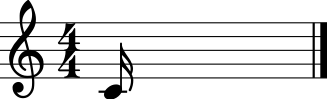

In [531]:
s1 = stream.Stream()
n1 = note.Note()
n1.midi = 60
n1.duration.quarterLength = 0.25
s1.append(n1)
s1.show()

In [569]:
sc = stream.Score()
for i in inverso:
    n = note.Note(midi=i[1], quarterLength=i[0])
    sc.append(n)

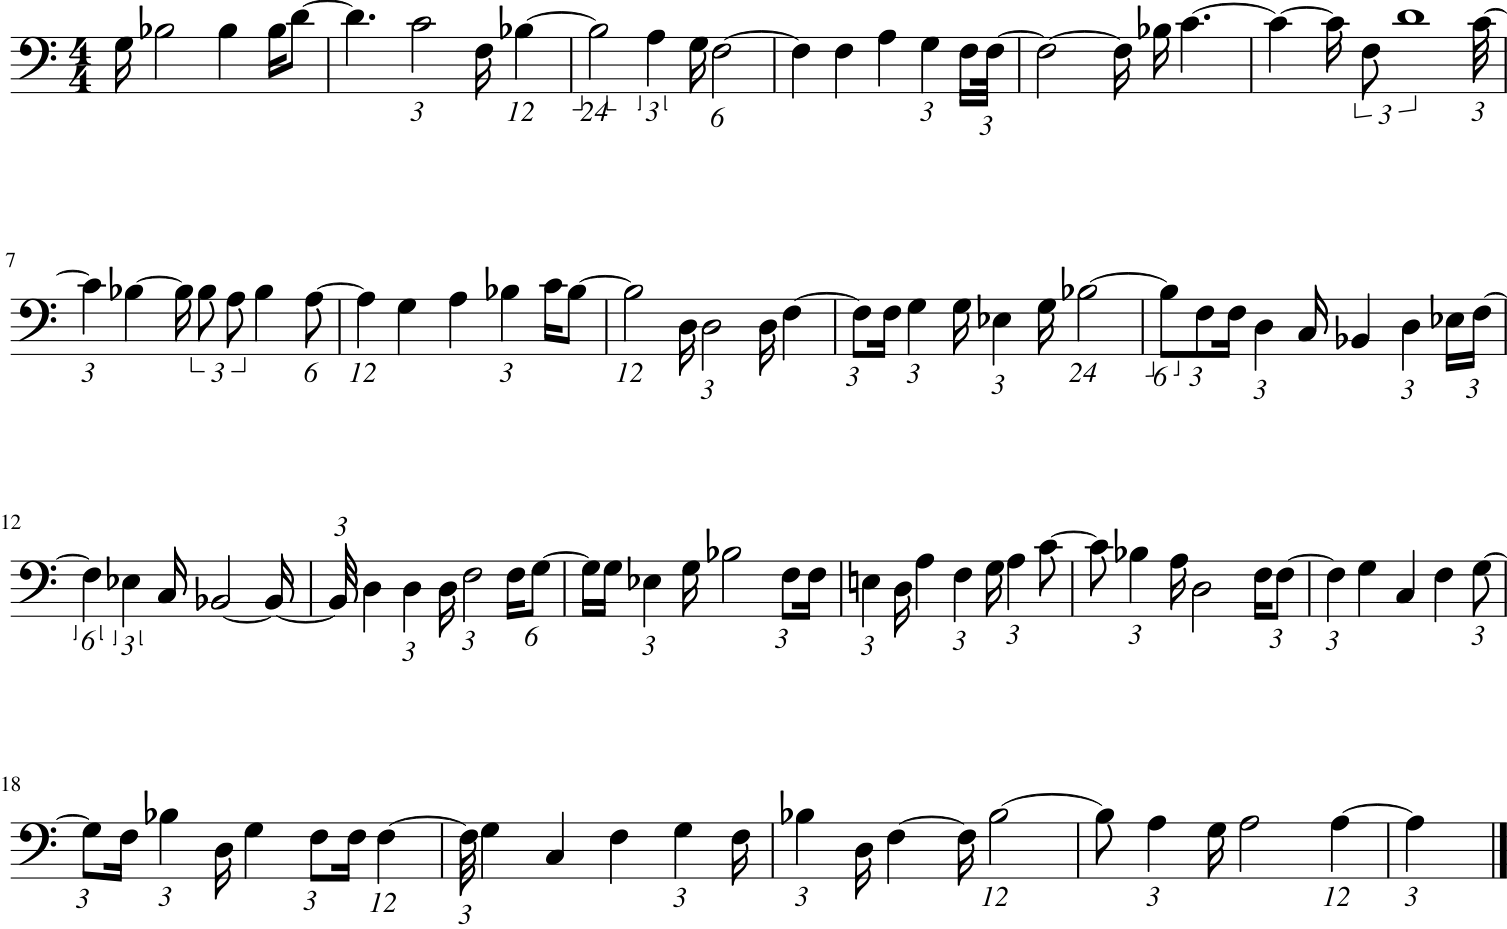

In [570]:
sc.show()

In [575]:
from music21 import *

In [576]:
mf = midi.translate.streamToMidiFile(sc)
mf.open('gerado.mid', 'wb')
mf.write()
mf.close()

In [580]:
!ls gerad*

gerado.mid
